### TODO
* Input correct catalogue
* set object id
* set sampling count
* be sure of samplepoints
* fix standard deviation

In [1]:
#catalogue = "gds/jades/phot/hlsp_jades_jwst_nircam_goods-s-deep_photometry_v1.0_catalog_large_withSpec.fits"
catalogue = "gds/jades/phot/hlsp_jades_jwst_nircam_goods-s-deep_photometry_v1.0_catalog.fits"
objectsIDs = [75224]
sampleCnt = 100000
template = "EMlines"
excludeZeros = False

In [2]:
import eazy, os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from math import ceil, floor
from copy import deepcopy as copy

from astropy import units as u
from astropy.cosmology import Planck18
from astropy.io import fits
from astropy.table import Table, join, hstack, vstack
from astropy.visualization import ZScaleInterval as zs
from astroquery.mast import Observations as obs
from IPython.utils import io
from matplotlib.transforms import Affine2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import eazy_routines as ez
import helper_module as hmod

if not os.path.exists('templates'):
    eazy.symlink_eazy_inputs()

cosmo = Planck18

if "temp" not in os.listdir():
    os.mkdir("temp")

In [3]:
# log all camera filters
flt = eazy.filters.FilterFile()

filts_nircam = {
        'F090W': 363,
        'F115W': 364,
        'F150W': 365,
        'F182M': 370,
        'F200W': 366,
        'F210M': 371,
        'F277W': 375,
        'F335M': 381,
        'F356W': 376,
        'F410M': 383,
        'F430M': 384,
        'F444W': 358,
        'F460M': 385,
        'F480M': 386
}

filts_HST = {
        'F105W': 202,
        'F125W': 203,
        'F140W': 204,
        'F160W': 205,
        'F435W': 233,
        'F606W': 214,
        'F775W': 216,
        'F814W': 239,
        'F850LP': 240
}

filts = {**filts_nircam, **filts_HST}

mw_reddening = ez.get_atten_dict(filts)

# get zeropoints
zps = [1.0]*len(filts)

In [4]:
#=== load data

inpath = os.path.join(os.getenv('astrodata'), catalogue)
catName = inpath.split('/')[-1].split('.')[0]

# print the meta info
with fits.open(inpath) as hdul:
    print(hdul.info())

# load photometry table
tab = Table.read(inpath, hdu=6)
tab_redshifts = Table.read(inpath, hdu=9)

#=== make EAZY table

# load fluxes
# CIRC1: 0.10 arcsec aperture (see README)
ext = '_CIRC1'
cols_fluxes = hmod.get_matches(ext, tab.columns, exclude='_ei')#!correct?
cols_f = np.sort(hmod.get_matches(ext, cols_fluxes, exclude='_e'))#!correct? NMAD?? 50% percentile
cols_fe = np.sort(hmod.get_matches('_e', cols_fluxes))#!correct?
cols_fluxes = list(np.vstack([cols_f, cols_fe]).T.flatten())#!correct?
cols = list(np.insert(cols_fluxes, 0, ['ID', 'RA', 'DEC']))

tab = join(tab, tab_redshifts['ID', 'z_spec'], join_type='inner', keys='ID')
tab_out = tab[cols]

# convert from nJy to uJy
# and apply MW reddening
keys = np.array(list(mw_reddening.keys()))
for c in cols_fluxes:
    tab_out[c].unit = u.nJy
    tab_out[c] = tab_out[c].to(u.uJy)
    
    # apply MW reddening
    matches = hmod.get_matches(keys, c, get_idxs=True)
    key = keys[np.int32(matches[:,0])][0]
    tab_out[c] *= mw_reddening[key]
    
# rename columns
for c in cols_f:
    cnew = c.replace(ext, '_flux')
    tab_out.rename_column(c, cnew)

for c in cols_fe:
    cnew = c.replace(ext+'_e', '_err')
    tab_out.rename_column(c, cnew)

#=== apply MW reddening
#atten_dict = ez.get_atten_dict(filts_eazyres, filts_str)
#degr_image_sig *= atten_dict[filt] / 100. # uJy

# pick out object IDs
tab_target_index = []
for i in range(len(tab_out)): 
    if tab_out['ID'][i] in objectsIDs:
        tab_target_index.append(i)
tab_target_index = np.array(tab_target_index)
tab_target = tab_out[tab_target_index]

# make artifficial catalogue with variation within flux errors
gaussian = lambda x, mu, sig: np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
flux_errs = np.asarray(tab_target[['{}_err'.format(f) for f in filts.keys()]])
flux_errs = np.array([e for e in flux_errs[0]])
fluxes = np.array(tab_target[['{}_flux'.format(f) for f in filts.keys()]])
fluxes = np.array([f for f in fluxes[0]])

#assuming that std=e/f https://physics.nist.gov/cgi-bin/cuu/Info/Constants/definitions.html #!probably not correct

#add to dict if no nan entries
filtermess = {f: [fluxes[i],flux_errs[i]] for i, f in enumerate(filts.keys()) if not np.isnan(fluxes[i]) and not np.isnan(flux_errs[i])}

#create distribution of fluxes
fluxes_dist = np.array([np.random.normal(f, e/f, sampleCnt) for f, e in filtermess.values()])
if excludeZeros: fluxes_dist = np.array([np.array([f for f in fluxes_dist[i] if f > 0]) for i in range(len(fluxes_dist))])
serieses = fluxes_dist.T

#create synthetic catalogue with fluxes
tab_synthetic = Table()
tab_synthetic['ID'] = np.arange(sampleCnt)
tab_synthetic['RA'] = tab_target['RA'][0]
tab_synthetic['DEC'] = tab_target['DEC'][0]
for i, f in enumerate(filtermess.keys()):
    tab_synthetic['{}_flux'.format(f)] = serieses[:,i]
    tab_synthetic['{}_err'.format(f)] = np.full(sampleCnt, filtermess[f][1])

#add to target table
#import vstack

tab_target = vstack([tab_target, tab_synthetic])

# save EAZY table
tab_target.write('temp/eazy_input.fits', format='fits', overwrite=True)

Filename: /home/ubuntu-compute/Desktop/astrodata/gds/jades/phot/hlsp_jades_jwst_nircam_goods-s-deep_photometry_v1.0_catalog.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      13   ()      
  1  FILTERS       1 BinTableHDU     33   23R x 12C   [6A, E, E, E, E, E, E, E, E, E, E, E]   
  2  FLAG          1 BinTableHDU    161   47181R x 75C   [J, D, D, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E]   
  3  SIZE          1 BinTableHDU    100   47181R x 43C   [J, D, D, E, D, D, D, D, J, J, J, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
  4  CIRC          1 BinTableHDU    856   47181R x 423C   [J, D, D, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E,

None


In [5]:
runTime = int(time.time())

In [6]:
#=== set up paths for eazy

# catalog paths
cat_name = 'eazy_input'
cat_path = f'temp/{cat_name}.fits'
keys_id = ['ID', 'RA', 'DEC']

# template names and paths
"""ftempl_strs = ['corr_sfhz_13', 'blue_sfhz_13', 'fsps_45k']"""
"""templ_paths = [f"templates/sfhz/{ftempl_strs[0]}.param",
               f"templates/sfhz/{ftempl_strs[1]}.param",
               f"templates/templates-c2020/45k/{ftempl_strs[2]}.param"]"""
ftempl_strs = [
    'EMextreme.param',
    'EMlines.param',
    'fsps_45k_0.3removed',
    'fsps_45k',
    'fsps_60k',
    'carnall_sfhz_13',
    'corr_sfhz_13',
    'blue_sfhz_13',
    'eazy_v1.1_lines.spectra', 
    'eazy_v1.3.spectra',
    'br07_default.spectra',
    'pegase.spectra',
    'pegase13.spectra',
    'cww+kin.spectra'
    ]
ftempl_str = [e for e in ftempl_strs if template in e][0]
templ_path = f"templates/{ftempl_str}"
out_name = f"ID{objectsIDs[0]}_{template}_{sampleCnt}"
out_path = f"eazy-output/{out_name}_{runTime}"
paths = [templ_path, out_path]

In [7]:
# iterate over tempalte sets
tpath, opath = paths
    
params = {"cat_path": cat_path,
            "templ_path": tpath,
            "out_path": opath,
            "FIX_ZSPEC": 'n',
            "USE_ZSPEC_FOR_REST": 'n',
            "Z_MAX": 12.0,
            "H0": cosmo.H0,
            "OMEGA_M": cosmo.Om0,
            "OMEGA_L": cosmo.Ode0,
            "CATALOG_FORMAT": 'fits'}

# write eazy config files
filt_num, fnames = ez.write_config(cat_name, filts, zps, keys_id,
                                    out_path=opath)

# run eazy
#idx = np.array([0])
idx = None
zout, hdu = ez.run_eazy(params, fnames, n_proc=-1, idx=idx)

Read default param file: /home/ubuntu-compute/miniconda3/envs/astro/lib/python3.11/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: temp/eazy_input.fits
   >>> NOBJ = 100001
F090W_flux F090W_err (363): jwst_nircam_f090w
F115W_flux F115W_err (364): jwst_nircam_f115w
F150W_flux F150W_err (365): jwst_nircam_f150w
F182M_flux F182M_err (370): jwst_nircam_f182m
F200W_flux F200W_err (366): jwst_nircam_f200w
F210M_flux F210M_err (371): jwst_nircam_f210m
F277W_flux F277W_err (375): jwst_nircam_f277w
F335M_flux F335M_err (381): jwst_nircam_f335m
F356W_flux F356W_err (376): jwst_nircam_f356w
F410M_flux F410M_err (383): jwst_nircam_f410m
F430M_flux F430M_err (384): jwst_nircam_f430m
F444W_flux F444W_err (358): jwst_niriss_f444w
F460M_flux F460M_err (385): jwst_nircam_f460m
F480M_flux F480M_err (386): jwst_nircam_f480m
F105W_flux F105W_err (202): hst/wfc3/IR/f105w.dat
F125W_flux F125W_err (203): hst/wfc3/IR/f125w.dat
F140W_flux F140W_err (204): hst/wfc3/IR/f140w.dat
F160W_flux F160W_e

Set sys_err = 0.01 (positive=True)


/home/ubuntu-compute/miniconda3/envs/astro/lib/python3.11/site-packages/eazy/photoz.py:1326: RuntimeWarning: invalid value encountered in log10
  self.prior_mag_cat += -2.5*np.log10(np.squeeze(self.fnu[:,ix]))


KeyboardInterrupt: 

In [ ]:
#find latest runTime in folder:
#runTime = int(np.sort([int(f.split('_')[-1]) for f in os.listdir('eazy-output')])[-1])
#outpaths = 'eazy-output/{ftempl}_{runTime}/gds_jades_eazy.zout.fits'
outpath = out_path


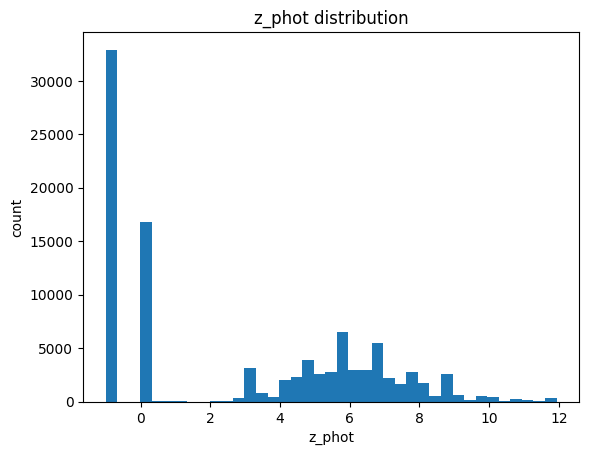

In [ ]:
tbl = Table.read(os.path.join(outpath, 'eazy_input.zout.fits'))
z_phot = tbl['z_phot']

#plot z_phot distribution
plt.hist(z_phot, bins=int(np.sqrt(len(z_phot)))//8)
plt.title('z_phot distribution')
plt.xlabel('z_phot')
plt.ylabel('count')
plt.show()